In [ ]:
# This command checks the status of the NVIDIA GPU available in the environment.
# It prints out details like GPU model, driver version, CUDA version, and memory usage.

!nvidia-smi

# Google drive Mounting
---------
*   This code mounts Google Drive to the Colab enviroment.
*   It allows you to access the stored files in your drive.
*   If you want to store all input and output data on the drive, then only run the below code and kindly change the path wherever required.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Below, markdown will help in unziping the zip file and stored at desired location.
* "data.zip" file is shared seperately.

In [ ]:
# Define the path to the zip file
zip_file_path = '/content/data.zip'

# Define the directory where the files will be extracted
extract_dir = '/content'

# Extract the zip file
!unzip {zip_file_path} -d {extract_dir}

# Optionally, remove the zip file if no longer needed
!rm {zip_file_path}

# Change directory to the extracted folder
import os
os.chdir(extract_dir)

# Move media files to the desired location if needed
# !cp -R *.mp4 ../


# Libary Installation
------------
1. '**roboflow**' is a tool for managing datasets and training computer vision models.
2. '**Supervision**' for visualization and extracting metrics from our predicted model results.
3. '**Ultralytics**' package, which includes the YOLO (You look only once) model
and its implementation.
4. '**Numpy**' for numerical operations.
5. '**os**' for efficient interacting with the operating system.
6. '**PIL**' Python imaging libary for image manipulation.


In [ ]:
pip install ultralytics -q

In [ ]:
!pip install roboflow supervision==0.19.0 -q

In [ ]:
from ultralytics import YOLO # This import the YOLO class from the ultralytics package

In [ ]:
import supervision as sv
import os
import cv2
import numpy as np
from PIL import Image

## Data Arrangement
---
* Here, directories are created to manage and arrange the data.
* 'frames' this directory is created to store video frames. Further, these frames are utilised for dataset generation.
* 'hetamap' this directory is used to store heatmap of the output processed video.
* 'graphs' this directory is used to store graphs of the output processed video.

In [ ]:
import os

FRAMES_DIR = "/content/frames"
os.mkdir(FRAMES_DIR)

In [ ]:
import os

HEATMAP_DIR = "/content/heatmap"
os.mkdir(HEATMAP_DIR)

In [ ]:
import os

GRAPHS_DIR = "/content/graphs"
os.mkdir(GRAPHS_DIR)

###### This markdwon cell, has code which use the get_video_frames_generator from Supervision libary to get a generator which yields the frames of the video.The genrator which yields the frames are stored in frames directory.  

* Here, "input_1.mp4" file is shared separately.

In [ ]:
# Create a generator that yields frames from the video
frame_generator=sv.get_video_frames_generator("/content/input_1.mp4")

# Iterate through the frames
for i, frame in enumerate(frame_generator):
  img = Image.fromarray(frame)
  img.save(f"{FRAMES_DIR}/{i}.jpg")

print(f"Saved frames to {FRAMES_DIR}")

## Model Training

1. model = YOLO("yolov8s.pt")
* This line loads a pre-trained YOLOv8 model.
"yolov8s.pt" refers to the small variant of YOLOv8. The 's' stands for small.
The .pt file contains the pre-trained weights for the model.

2. results = model.train()
* This line starts the training process for the model using the specified parameters.

3. Training parameter
* data=".."
* This specifies the path to the YAML file containing dataset information.
The YAML file typically includes paths to training and validation images, as well as class names.

* epochs=10
* This sets the number of training epochs to 10.
An epoch is one complete pass through the entire training dataset.

* imgsz=640
* This sets the input image size for training to 640x640 pixels.
YOLO models typically use square input images.

In [ ]:
model=YOLO("yolov8s.pt")
results=model.train(data="/content/data/data.yaml",epochs=15,imgsz=640)

### Loading of a trained model
* Below, markdown will load the particular trained model from given path.
* "**best.pt**" usually contains the weights that performed best on the validation set during training.

In [ ]:
models=YOLO("/content/runs/detect/train/weights/best.pt")

### Occupancy analysis

This markdown cell will perform following things
* This defines a callback function named callback that takes a numpy array x as input and returns a sv.Detections object.

* x: np.ndarray:
This specifies that the input x is expected to be a numpy array, likely representing an image.

* -> sv.Detections:
This indicates that the function will return a Detections object from the Supervision library.

In [ ]:
def callback(x: np.ndarray) -> sv.Detections:
    results = models(x, conf=0.20, iou=0.3)
    detections = sv.Detections.from_ultralytics(results[0])
    return detections

Zone defining
* Setting up a list of the zones to be used with PolygonZone and these, can get polygon coordinates using this [web utility](https://roboflow.github.io/polygonzone/). Although,these coordinates changes with different video inputs and user specific zones.

In [ ]:
# Polygons From PolygonZone

zones = [
    {
        'name': "Zone 1",
        'polygon': np.array([[98, 349],[98, 309],[516, 309],[516, 350]]),
         'max': 32
    },
    {
        'name': 'Zone 2',
        'polygon': np.array([[76, 202],[514, 205],[514, 283],[73, 278]]),
         'max': 38
    },
    {
        'name': 'Zone 3',
        'polygon': np.array([[74, 87],[515, 93],[516, 172],[73, 171]]),
         'max': 46
    },
    {
        'name': 'Zone 4',
        'polygon': np.array([[71, 0],[71, 62],[512, 62],[511, 0]]),
         'max': 48
    }
]

#### Establishing Supervision
To get analysis about parking lot like how much space is occupied. So, we need to gather information about how many vehicles are there in a particluar zone.
* For our use case, we will use the following features of Supervision. Refer to the linked documentation for more details:

* **ByteTrack**: To track the location of our vehicles, so we can assess how long they are parked
* **InferenceSlicer**: A helper utility to run SAHI on our model
* **TriangleAnnotator**: To help visualize the locations of the vehicles
* **HeatMapAnnotator**: To generate heatmaps so we can identify our busiest areas
* **PolygonZone, PolygonZoneAnnotator**: To help count and identify vehicles in
our respective zones and the annotator to help visualize those zones.

**Step 1**- To track the position of vehicle, we Initialize tracker. Supervision has ByteTracker which does this job in efficient manner.

**Step 2**- Supervision's InferenceSlicer is used. It involves dividing a larger image into smaller slices, performing inference on each slice, and then merging the detections.

**Step 3**- To locate where vehicle is, we annoate it using TriangleAnnotator.We define proper size for this annotator like base and height.

**Step 4**- Function setup_zones is defined for detection.

* The function setup_zones initializes each **zone** in the zones list with a history list, a **PolygonZone** object, and a **PolygonZoneAnnotator** object.

* Each zone's **PolygonZone** object defines the geometric area of the zone.

* Each zone's **PolygonZoneAnnotator** object is used to annotate the frame with the zone's boundaries and other visual indicators.

* By the end of this function, each **zone** in the zones list is equipped with the necessary components to track and annotate objects within its defined polygonal area.

**Step 5**- To process each frame function process_frame is defined.

* The process_frame function performs object detection on a given frame, updates the object tracker, and annotates the frame with triangle annotations for detected objects.

* It initializes a heatmap if not provided and annotates it with detected objects.
The function then processes each defined zone, checking for the presence of objects within the zone, updating the zone's history, and annotating both the frame and heatmap with zone information.

* Finally, it returns the annotated frame and heatmap.

In [ ]:
# Initialize object tracker
tracker = sv.ByteTrack()

# Set up inference slicer for efficient processing of large images
slicer = sv.InferenceSlicer(
    callback=callback,
    slice_wh=(400, 400),
    overlap_ratio_wh=(0.2, 0.2),
    thread_workers=10,
    iou_threshold=0.5
)

# Initialize annotators
triangle_annotator = sv.TriangleAnnotator(
    base=20,
    height=20
)
heat_map_annotator = sv.HeatMapAnnotator()

# Function to set up zones for detection
def setup_zones(frame_wh):
  if zones:
    for zone in zones:
      zone['history'] = []   # Initialize history for each zone
      # Create a PolygonZone for each defined zone
      zone['PolygonZone'] = sv.PolygonZone(
          polygon=zone['polygon'],
          frame_resolution_wh=frame_wh
      )
      zone['PolygonZoneAnnotator'] = sv.PolygonZoneAnnotator(
        zone=zone['PolygonZone'],
        color=sv.Color.WHITE,
        thickness=2,
    )

# Main function to process each frame
def process_frame(frame,heatmap=None):
    # Perform object detection on the frame
    detections = slicer(image=frame)
    # Update tracker with new detections
    detections = tracker.update_with_detections(detections)

    # Create a copy of the frame for annotation
    annotated_frame = frame.copy()

    # Add triangle annotations for detected objects
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    if heatmap is None:
      heatmap = np.full(frame.shape, 255, dtype=np.uint8)

    heat_map_annotator.annotate(
      scene=heatmap,
      detections=detections
    )
    # Process each defined zone
    if zones:
      for zone in zones:
        zone_presence = zone['PolygonZone'].trigger(detections)
        zone_present_idxs = [idx for idx, present in enumerate(zone_presence) if present]
        zone_present = detections[zone_present_idxs]

        zone_count = len(zone_present)
        zone['history'].append(zone_count)


        annotated_frame = zone['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone['name']}: {zone_count}"
        )

        # Heatmap
        heatmap = zone['PolygonZoneAnnotator'].annotate(
            scene=heatmap,
            label=" "
        )

    return annotated_frame, heatmap

* After the supervision is established the followings thing is done.
* Firstly we try the model on single frame of a video which we can get it from frames directory and below code will do perform this and provides results.
* After that we process the entire video.

In [ ]:
image = cv2.imread("/content/frames/100.jpg")
image_wh = (image.shape[1],image.shape[0])
setup_zones(image_wh)

annotated_image, heatmap = process_frame(image)

sv.plot_image(annotated_image)
sv.plot_image(heatmap)

### Setting up Graph
* It is setup using matplotlib.
* This graph represents the history of detections (e.g., vehicles) within each defined zone and the percentage of zone occupancy over time.
* They provide a clear and concise visual representation of how each zone is being utilized.
* The generate_graphs function is designed to visualize the usage and occupancy data of different zones. It creates individual and combined plots for each zone, showing the history of detections and the percentage of occupancy, and returns these graphs as images. These visualizations are crucial for monitoring, analyzing, and reporting the zone usage data effectively.

In [ ]:
# Credit to https://matplotlib.org/matplotblog/posts/matplotlib-cyberpunk-style/ for graph styles
%matplotlib agg
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def generate_graphs(max_frames):
  plt.ioff()
  # Plot Styles
  plt.style.use("seaborn-dark")
  for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
      plt.rcParams[param] = '#212946'

  for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
      plt.rcParams[param] = '0.9'


  dataframe = pd.DataFrame()
  graphs = {}


  for zone in zones:
    percentage_history = [(count/zone['max'])*100 for count in zone['history']]
    dataframe[zone['name']] = percentage_history
    plt.title(f'{zone["name"]} Usage')

    # Extra Styles
    fig, ax1 = plt.subplots()
    ax1.grid(color='#2A3459')

    # Data
    ax1.plot(zone["history"])

    # Axis Labeling
    plt.ylabel('Vehicles')
    plt.ylim(top=zone["max"])
    plt.xlim(right=max_frames)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Occupied Percentage (%)')

    # Export Graph Image
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    graphs[zone['name']] = Image.open(buf)
    plt.close(fig)


  plt.ioff()
  dataframe.plot()

  # Axis
  plt.ylabel('Occupied (%)', fontsize=15)
  plt.ylim(top=100)
  plt.xlim(right=max_frames)

  # Export combined
  buf = BytesIO()
  plt.savefig(buf, format='png', bbox_inches='tight')
  buf.seek(0)

  plt.close()

  graphs['combined_percentage'] = Image.open(buf)

  return graphs

In [ ]:
generate_graphs(400)['combined_percentage']

#### Processing a Video
* Now, we can process the video to get detections from the entire video. This process is carried out in following ways

* **VIDEO_PATH** and **MAIN_OUTPUT_PATH** these set the path for the input video and the output video.

* **frames_generator** is initialized to generate frames from the input video.

* **video_info** contains metadata about the video, such as resolution and total frames.

* **setup_zones(video_info.resolution_wh)** Initializes the zones with the resolution of the video frames.

* Supervision's **VideoSink** helps to write the annotated frames into the output video file.

* Process each frame by iterating through each frame in the video using the **frame_generator**

* Calling **process_frame** function to perform inference on the current frame. This function will return the annotated frame and update the heatmap.

* Lastly, writing the processed and annotated frame to the output video file.


In [ ]:
VIDEO_PATH = "/content/input_1.mp4" # Path to input video
MAIN_OUTPUT_PATH = "/content/parkinglot_annotated_output_1.mp4" # Path to store ouput video
frames_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

setup_zones(video_info.resolution_wh)


with sv.VideoSink(target_path=MAIN_OUTPUT_PATH, video_info=video_info) as sink:
  heatmap = None
  for i, frame in enumerate(frames_generator):
    print(f"Processing frame {i}")

    # Infer
    annotated_frame, heatmap = process_frame(frame, heatmap)

    # Save the latest heatmap
    Image.fromarray(heatmap).save(f"/content/heatmap/{i}.jpg")

    # Create Graphs
    graphs = generate_graphs(video_info.total_frames)
    graph = graphs["combined_percentage"].convert("RGB")
    graph.save(f"/content/graphs/{i}.jpg")

    sv.plot_image(annotated_frame)

    # Send as frame to video
    sink.write_frame(frame=annotated_frame)

* Below code is designed to take a series of numbered images (e.g., 0.jpg, 1.jpg, 2.jpg, etc.) from a specified directory (graphs and heatmap) and combine them into a video. It's particularly useful for creating videos from sequences of graphs or heatmaps, which could represent the evolution of some data over time.

* After the code is run it gnerates two output video namely "**parkinglot_graph_output_1.mp4**" and "**parkinglot_heatmap_output_1.mp4**" respectively. However, these videos are shared separately.

* This parkinglot_graph_output video will provide inforamtion about number of cars present in a particular zone over the time.

In [ ]:
import cv2
def create_videos_from_dir(dir,output):
  images = len(os.listdir(dir))-1

  sample_img_path = os.path.join(dir,f"1.jpg")
  sample_img = cv2.imread(sample_img_path)
  height, width, channels = sample_img.shape
  video_info = sv.VideoInfo(width=width,height=height,fps=24,total_frames=images)

  with sv.VideoSink(target_path=output, video_info=video_info) as sink:
    for i in range(images):
      path = os.path.join(dir,f"{i}.jpg")
      img = cv2.imread(path)
      sink.write_frame(frame=img)

# Graphs
create_videos_from_dir("/content/graphs","/content/parkinglot_graph_output_1.mp4")

# Heatmap
create_videos_from_dir("/content/heatmap","/content/parkinglot_heatmap_output_1.mp4")

### Analytics of Parking Lot


1.   Zone wise analysis


* Below, code calculate and print various occupancy statistics for each zone in a list of zones.

In [ ]:
import statistics
for zone in zones:
    occupancy_percent_history = [(count/zone['max'])*100 for count in zone['history']]
    average_occupancy = round(statistics.mean(occupancy_percent_history))
    median_occupancy = round(statistics.median(occupancy_percent_history))
    highest_occupancy = round(max(occupancy_percent_history))
    lowest_occupancy = round(min(occupancy_percent_history))
    print(f"{zone['name']} had an average occupancy of {average_occupancy}% with a median occupancy of {median_occupancy}%.")


2.   Entire zone analysis


* Below, code calculates occupancy statistics for the entire parking lot by combining data from all zones.

In [ ]:
lot_history = []
for zone in zones:
    for idx, entry in enumerate(zone['history']):
      if(idx >= len(lot_history) or len(lot_history)==0): lot_history.append([])
      lot_history[idx].append(zone['history'][idx]/zone['max'])

lot_occupancy_history = [sum(entry)/len(entry)*100 for entry in lot_history]

average_occupancy = round(statistics.mean(lot_occupancy_history))
median_occupancy = round(statistics.median(lot_occupancy_history))
highest_occupancy = round(max(lot_occupancy_history))
lowest_occupancy = round(min(lot_occupancy_history))

print(f"The entire lot had an average occupancy of {average_occupancy}% with a median occupancy of {median_occupancy}%.")

In [ ]:
print(lot_occupancy_history)

### Total Occupancy

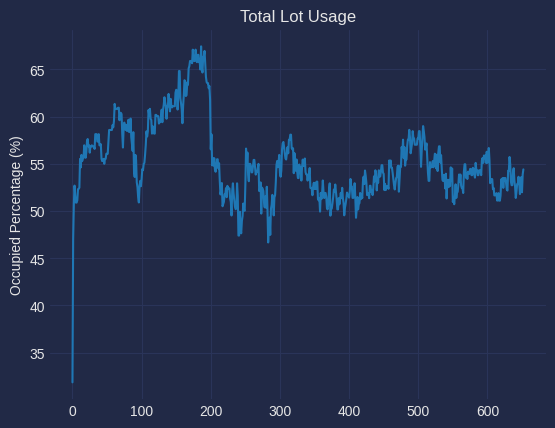

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.title('Total Lot Usage')
ax1.grid(color='#2A3459')
ax1.set_ylabel('Occupied Percentage (%)')
plt.plot(lot_occupancy_history)
plt.show()